# Code to process the data from CellNexus which is the curated and harmonized human cell atlas from CellXGene


In [2]:
import os
os.environ["PATH"] += os.pathsep + "/gpfs/apps/icl/software/CUDA/12.2.2/nvvm/bin:/gpfs/apps/icl/software/CUDA/12.2.2/bin"
LD_LIBRARY_PATH="/apps/icl/software/CUDAcompat/12.2-535.161.08/lib"
os.environ["LD_LIBRARY_PATH"]=os.pathsep+LD_LIBRARY_PATH

In [1]:
#importing the needed packages
import scanpy as sc
import os
from geneformer import TranscriptomeTokenizer, EmbExtractor, DataCollatorForCellClassification
import datasets
import json
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import pickle
import numpy as np
from datetime import datetime
import anndata 
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

/hpcfs/users/a1841503/myconda/envs/geneformer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reading all the files on cell nexus that were locally downloaded

In [ ]:
#Methods to find all blood files
def find_all_blood_tissue_files():
    """
    Loop through numbered .h5ad files in the specified directory
    and return a list of all files containing 'blood' in tissue_groups
    """
    base_dir = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/cellNexusAnndata/"
    
    file_counter = 1
    blood_files = []
    
    while True:
        # Construct filename
        filename = f"file{file_counter}.h5ad"
        filepath = os.path.join(base_dir, filename)
        
        # Check if file exists
        if not os.path.exists(filepath):
            print(f"File {filename} not found. Stopping search.")
            break
            
        try:
            print(f"Checking {filename}...")
            
            # Read the h5ad file
            data = sc.read_h5ad(filepath)
            
            # Get unique tissue groups
            tissue_groups = data.obs['tissue_groups'].unique()
            print(f"Tissue groups in {filename}: {tissue_groups}")
            
            # Check if any tissue group contains 'blood'
            blood_found = any('blood' in str(group).lower() for group in tissue_groups)
            
            if blood_found:
                print(f"\n✓ Found blood tissue in {filename}!")
                blood_files.append(filepath)
            else:
                print(f"No blood tissue found in {filename}") 
                
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            
        file_counter += 1
    
    return blood_files


# Run the Method
result_files = find_all_blood_tissue_files()

if result_files:
    print(f"\nResult: Blood tissue found in the following files:")
    for f in result_files:
        print(f"  {f}")
else:
    print("\nNo file with blood tissue groups was found.")


File file1.h5ad not found. Stopping search.

No file with blood tissue groups was found.


In [ ]:
# Paths to your train and test files
file_paths = [
    "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/anndata_singlecell/blood_samples/cellnexus_blood_train.h5ad",
    "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/anndata_singlecell/blood_samples/cellnexus_blood_test.h5ad"
]

seen_dataset_ids = set()
anndata_list = []

for filepath in file_paths:
    if not os.path.exists(filepath):
        print(f"File {filepath} not found. Skipping.")
        continue

    try:
        print(f"Reading {filepath}...")
        data = sc.read_h5ad(filepath)
        # Filter for blood tissue only
        blood_data = data[data.obs["tissue_groups"] == "blood"]
        if blood_data.shape[0] == 0:
            print(f"No blood cells in {filepath}. Skipping.")
            continue
        file_dataset_ids = set(blood_data.obs['dataset_id'].unique())
        # Check if any dataset_id in this file is already seen
        if file_dataset_ids & seen_dataset_ids:
            print(f"Skipping {filepath} (already have dataset_id(s): {file_dataset_ids & seen_dataset_ids})")
        else:
            print(f"Adding {filepath} (new dataset_id(s): {file_dataset_ids})")
            seen_dataset_ids.update(file_dataset_ids)
            anndata_list.append(blood_data)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")

if anndata_list:
    combined_anndata = anndata.concat(anndata_list, join='outer', label='batch', index_unique=None)
    print("Combined AnnData object created.")
else:
    print("No new AnnData objects to combine.")

Reading /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/anndata_singlecell/blood_samples/cellnexus_blood_train.h5ad...
Adding /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/anndata_singlecell/blood_samples/cellnexus_blood_train.h5ad (new dataset_id(s): {'ebc2e1ff-c8f9-466a-acf4-9d291afaf8b3', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', 'd7d7e89c-c93a-422d-8958-9b4a90b69558', '01ad3cd7-3929-4654-84c0-6db05bd5fd59', '9dbab10c-118d-496b-966a-67f1763a6b7d', '2a498ace-872a-4935-984b-1afa70fd9886', 'cf83c98a-3791-4537-bbde-a719f6d73c13', '242c6e7f-9016-4048-af70-d631f5eea188', '3c75a463-6a87-4132-83a8-c3002624394d', 'bd65a70f-b274-4133-b9dd-0d1431b6af34', '19e46756-9100-4e01-8b0e-23b557558a4c', 'de2c780c-1747-40bd-9ccf-9588ec186cee'})
Reading /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/anndata_singlecell/blood_samples/cellnexus_blood_test.h5ad...
Skipping /hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/anndata_singlecell/blood_samples/cellnexus_blood_test.h5ad (already h

In [4]:
(file_dataset_ids,seen_dataset_ids)

({'01ad3cd7-3929-4654-84c0-6db05bd5fd59',
  '19e46756-9100-4e01-8b0e-23b557558a4c',
  '242c6e7f-9016-4048-af70-d631f5eea188',
  '2a498ace-872a-4935-984b-1afa70fd9886',
  '3c75a463-6a87-4132-83a8-c3002624394d',
  '9dbab10c-118d-496b-966a-67f1763a6b7d',
  'bd65a70f-b274-4133-b9dd-0d1431b6af34',
  'cf83c98a-3791-4537-bbde-a719f6d73c13',
  'de2c780c-1747-40bd-9ccf-9588ec186cee',
  'ebc2e1ff-c8f9-466a-acf4-9d291afaf8b3'},
 {'01ad3cd7-3929-4654-84c0-6db05bd5fd59',
  '19e46756-9100-4e01-8b0e-23b557558a4c',
  '218acb0f-9f2f-4f76-b90b-15a4b7c7f629',
  '242c6e7f-9016-4048-af70-d631f5eea188',
  '2a498ace-872a-4935-984b-1afa70fd9886',
  '3c75a463-6a87-4132-83a8-c3002624394d',
  '9dbab10c-118d-496b-966a-67f1763a6b7d',
  'bd65a70f-b274-4133-b9dd-0d1431b6af34',
  'cf83c98a-3791-4537-bbde-a719f6d73c13',
  'd7d7e89c-c93a-422d-8958-9b4a90b69558',
  'de2c780c-1747-40bd-9ccf-9588ec186cee',
  'ebc2e1ff-c8f9-466a-acf4-9d291afaf8b3'})

In [ ]:
base_dir = "/hpcfs/groups/phoenix-hpc-mangiola_laboratory/haroon/anndata_singlecell/"
file_counter = 1

while(True):
    filename = f"file{file_counter}.h5ad"
    filepath = os.path.join(base_dir, filename)
    if not os.path.exists(filepath):
        print(f"File {filename} not found. Stopping search.")
        break

    try:
        print(f"Checking {filename}...")
        data = sc.read_h5ad(filepath)
        # Filter for blood tissue only
        blood_data = data[data.obs["tissue_groups"] == "blood"]
        if blood_data.shape[0] == 0:
            print(f"No blood cells in {filename}. Skipping.")
            file_counter += 1
            continue
        file_dataset_ids = set(blood_data.obs['dataset_id'].unique())
        # Check if any dataset_id in this file is already seen
        if file_dataset_ids & seen_dataset_ids:
            print(f"Skipping {filename} (already have dataset_id(s): {file_dataset_ids & seen_dataset_ids})")
        else:
            print(f"Adding {filename} (new dataset_id(s): {file_dataset_ids})")
            seen_dataset_ids.update(file_dataset_ids)
            anndata_list.append(blood_data)
    except Exception as e:
        print(f"Error reading {filename}: {e}")

    file_counter += 1
    if anndata_list:
        combined_anndata = anndata.concat(anndata_list, join='outer', label='batch', index_unique=None)
        print("Combined AnnData object created.")
    else:
        print("No new AnnData objects to combine.")
    #if (file_counter==250):break

Checking file1.h5ad...
No blood cells in file1.h5ad. Skipping.
Checking file2.h5ad...
No blood cells in file2.h5ad. Skipping.
Checking file3.h5ad...
No blood cells in file3.h5ad. Skipping.
Checking file4.h5ad...
Skipping file4.h5ad (already have dataset_id(s): {'01ad3cd7-3929-4654-84c0-6db05bd5fd59'})
Combined AnnData object created.
Checking file5.h5ad...
Skipping file5.h5ad (already have dataset_id(s): {'01ad3cd7-3929-4654-84c0-6db05bd5fd59'})
Combined AnnData object created.
Checking file6.h5ad...
Skipping file6.h5ad (already have dataset_id(s): {'01ad3cd7-3929-4654-84c0-6db05bd5fd59'})
Combined AnnData object created.
Checking file7.h5ad...
Skipping file7.h5ad (already have dataset_id(s): {'01ad3cd7-3929-4654-84c0-6db05bd5fd59'})
Combined AnnData object created.
Checking file8.h5ad...
Skipping file8.h5ad (already have dataset_id(s): {'01ad3cd7-3929-4654-84c0-6db05bd5fd59'})
Combined AnnData object created.
Checking file9.h5ad...
Skipping file9.h5ad (already have dataset_id(s): {'01

In [ ]:
#no of datasets cause splitting by datasets as cells in a datasets share similar properties hence keeping the train, test split according to the dataset_id
len(seen_dataset_ids)

36

In [7]:
combined_anndata.write_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/complete_blood/anndata/combined_anndata.h5ad")

In [4]:
#Reading the file where the blood samples were found
data_dir="/hpcfs/users/a1841503/Geneformer/cellnexus/data/complete_blood/anndata/combined_anndata.h5ad"
data=sc.read_h5ad(data_dir)
data

AnnData object with n_obs × n_vars = 818287 × 37572
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'cell_annotation_azimuth_l2', 'nFeature_expr

In [9]:
#Viewing the tissue group categories
data.obs["tissue_groups"].unique().tolist()

['blood']

In [4]:
# Filter out cells where 'tissue_groups' is exactly 'blood'
filtered_data = data[data.obs["tissue_groups"] == "blood"]                                                                                                                                                                                                                                                                                              
(filtered_data.obs["tissue_groups"],filtered_data)

(cv19_0714_ln1_samples_AACTCTTTCGTTACAG-1_2___242c6e7f-9016-4048-af70-d631f5eea188_21     blood
 cv19_0714_ln1_samples_AAGGCAGAGGAGTAGA-1_2___242c6e7f-9016-4048-af70-d631f5eea188_21     blood
 cv19_0714_ln1_samples_ACATCAGAGCGTGTCC-1_2___242c6e7f-9016-4048-af70-d631f5eea188_21     blood
 cv19_0714_ln1_samples_ACCGTAACAGCCAGAA-1_2___242c6e7f-9016-4048-af70-d631f5eea188_21     blood
 cv19_0714_ln1_samples_ACGCAGCCAAAGGTGC-1_2___242c6e7f-9016-4048-af70-d631f5eea188_21     blood
                                                                                          ...  
 cv19_0711_ln2_samples_GTGTGCGAGGCGATAC-1_3___242c6e7f-9016-4048-af70-d631f5eea188_379    blood
 cv19_0711_ln2_samples_GTGTGCGTCTCCAGGG-1_3___242c6e7f-9016-4048-af70-d631f5eea188_379    blood
 cv19_0711_ln2_samples_GTGTTAGAGAAGGACA-1_3___242c6e7f-9016-4048-af70-d631f5eea188_379    blood
 cv19_0711_ln2_samples_GTGTTAGAGTCGCCGT-1_3___242c6e7f-9016-4048-af70-d631f5eea188_379    blood
 cv19_0711_ln2_samples_GTGTTAGCAATGAATG-

## Adding these colums for the geneformer to make predictions
### Can start form this step if the data is already in a h5ad format and all combined

In [8]:
# Adding theses colums for the geneformer to tokenize the data and make predictions
data.var["ensembl_id"] = data.var.index
data.obs["n_counts"] = data.X.sum(axis=1)
data.obs["joinid"] = list(range(data.n_obs))
data_dir="/hpcfs/users/a1841503/Geneformer/cellnexus/data/complete_blood/anndata/combined_anndata.h5ad"
data.write_h5ad(data_dir)

In [2]:
#Reading the filtered data
data=sc.read_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/complete_blood/anndata/combined_anndata.h5ad")

In [3]:
#Viewing the data
data

AnnData object with n_obs × n_vars = 818287 × 37572
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'cell_annotation_azimuth_l2', 'nFeature_expr

In [4]:
#Printing statistics
data.obs.describe()

,feature_count,filesize,mean_genes_per_cell,age_days,nFeature_expressed_in_sample,subsets_Mito_sum,subsets_Mito_detected,subsets_Mito_percent,subsets_Ribo_percent,metacell_2,...,metacell_512,nCount_RNA,sample_chunk,cell_chunk,sample_pseudobulk_chunk,metacell_1024,metacell_2048,metacell_4096,n_counts,joinid
count,818287.000000,8.182870e+05,818287.000000,8.182870e+05,818287.000000,817753.0,817753.0,817753.0,817753.0,818287.000000,...,21157.000000,8.182870e+05,818287.000000,818287.000000,818287.000000,0.0,0.0,0.0,8.182870e+05,818287.0000
mean,28726.736225,3.722424e+09,1519.733652,-2.027642e+08,1354.354437,0.0,0.0,0.0,0.0,242.185954,...,3.875739,2.858972e+06,1.015738,3.286095,1.428740,NaN,NaN,NaN,4.164228e+06,409143.0000
std,6421.362909,3.697213e+09,410.542796,6.279795e+08,727.002819,0.0,0.0,0.0,0.0,371.197729,...,2.809953,1.007185e+07,0.124459,3.469289,0.970999,NaN,NaN,NaN,1.269398e+07,236219.2542
min,15979.000000,2.935302e+07,792.511843,-2.147484e+09,200.000000,0.0,0.0,0.0,0.0,1.000000,...,1.000000,3.347300e-01,1.000000,1.000000,1.000000,NaN,NaN,NaN,4.609900e-01,0.0000
25%,22827.000000,7.238836e+08,1322.240238,1.259200e+04,847.000000,0.0,0.0,0.0,0.0,24.000000,...,1.000000,3.844272e+03,1.000000,1.000000,1.000000,NaN,NaN,NaN,5.604019e+03,204571.5000
50%,30695.000000,1.750038e+09,1452.771628,1.971000e+04,1230.000000,0.0,0.0,0.0,0.0,86.000000,...,4.000000,6.510307e+03,1.000000,2.000000,1.000000,NaN,NaN,NaN,9.885796e+03,409143.0000
75%,33155.000000,6.371839e+09,1870.413880,2.518500e+04,1695.000000,0.0,0.0,0.0,0.0,290.000000,...,6.000000,8.683675e+03,1.000000,4.000000,1.000000,NaN,NaN,NaN,9.999996e+03,613714.5000
max,58482.000000,1.393754e+10,2740.766627,3.394500e+04,9053.000000,0.0,0.0,0.0,0.0,3124.000000,...,12.000000,4.874281e+08,2.000000,15.000000,6.000000,NaN,NaN,NaN,4.874283e+08,818286.0000


In [5]:
lis=data.obs.age_days.head(100)

In [6]:
lis.describe()

count      100.0
mean     16790.0
std          0.0
min      16790.0
25%      16790.0
50%      16790.0
75%      16790.0
max      16790.0
Name: age_days, dtype: float64

In [7]:
(data.obs.dataset_id.value_counts(),data.obs.dataset_id.unique())

(dataset_id
 c7775e88-49bf-4ba2-a03b-93f00447c958    100000
 21d3e683-80a4-4d9b-bc89-ebb2df513dde    100000
 3faad104-2ab8-4434-816d-474d8d2641db     91199
 b0e547f0-462b-4f81-b31b-5b0a5d96f537     61382
 c2a461b1-0c15-4047-9fcb-1f966fe55100     54726
 59b69042-47c2-47fd-ad03-d21beb99818f     46252
 2a498ace-872a-4935-984b-1afa70fd9886     25000
 01ad3cd7-3929-4654-84c0-6db05bd5fd59     25000
 242c6e7f-9016-4048-af70-d631f5eea188     25000
 bd65a70f-b274-4133-b9dd-0d1431b6af34     25000
 9dbab10c-118d-496b-966a-67f1763a6b7d     25000
 19e46756-9100-4e01-8b0e-23b557558a4c     25000
 cf83c98a-3791-4537-bbde-a719f6d73c13     25000
 fa8605cf-f27e-44af-ac2a-476bee4410d3     22147
 30cd5311-6c09-46c9-94f1-71fe4b91813c     19324
 3c75a463-6a87-4132-83a8-c3002624394d     18145
 ebc2e1ff-c8f9-466a-acf4-9d291afaf8b3     16027
 218acb0f-9f2f-4f76-b90b-15a4b7c7f629     12560
 ed5d841d-6346-47d4-ab2f-7119ad7e3a35     11045
 db59611b-42de-4035-93aa-1ed39f38b467     10617
 de2c780c-1747-40bd-9ccf-958

## Adding age bins in data

In [8]:
age_years = data.obs['age_days'] / 365

# Define the bin edges (in years) and labels
bin_edges = [0, 3, 12, 20, 40, 50, 60, 70, np.inf]
bin_labels = ["Infancy", "Childhood", "Adolescence", "Young_Adulthood", 
              "Middle_Age", "Senior_50", "Senior_60", "Senior_70"]

# Create the age category column using pd.cut
data.obs['age_category'] = pd.cut(age_years, 
                                   bins=bin_edges, 
                                   labels=bin_labels, 
                                   right=False,)

In [9]:
data.obs.age_category.value_counts()

age_category
Senior_70          200559
Senior_50          175580
Young_Adulthood    128958
Senior_60          104021
Middle_Age          89645
Infancy             25000
Childhood           16027
Adolescence          1228
Name: count, dtype: int64

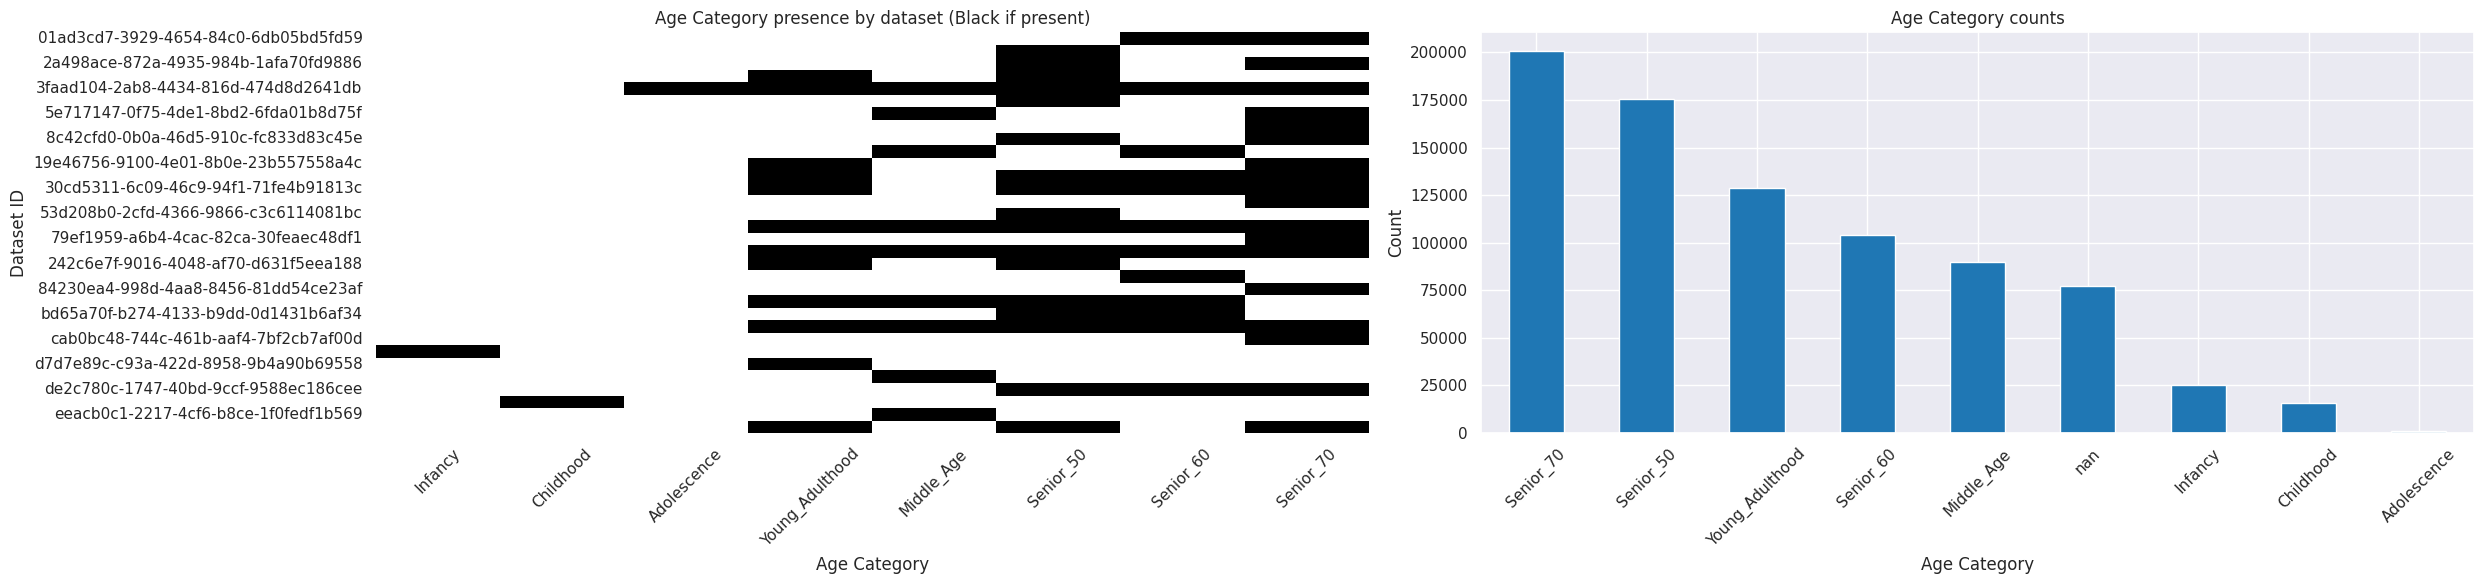

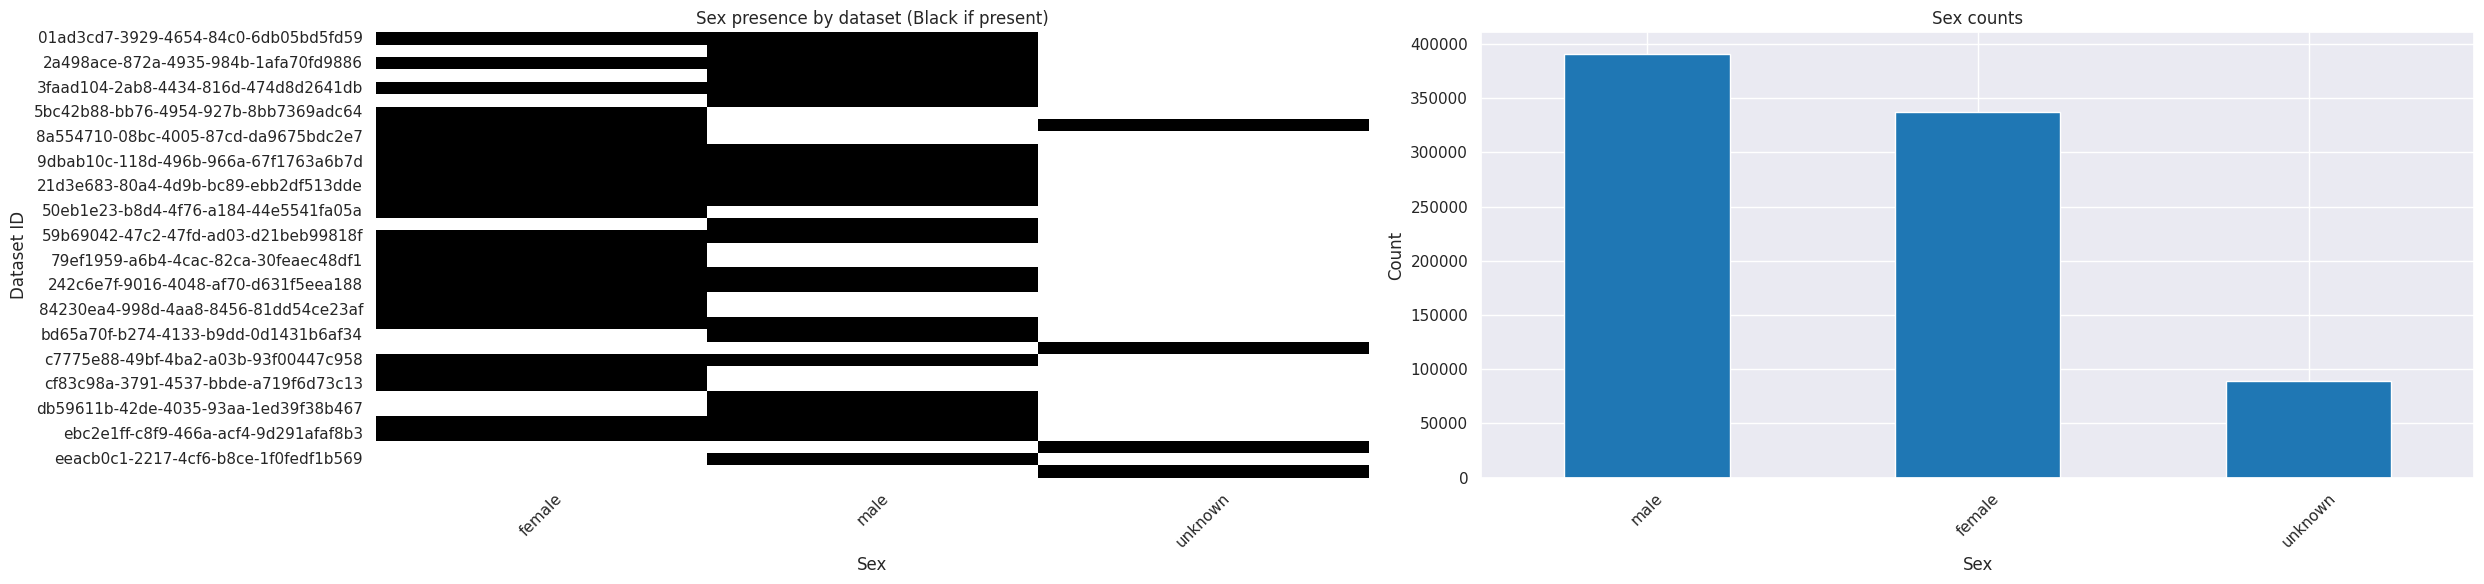

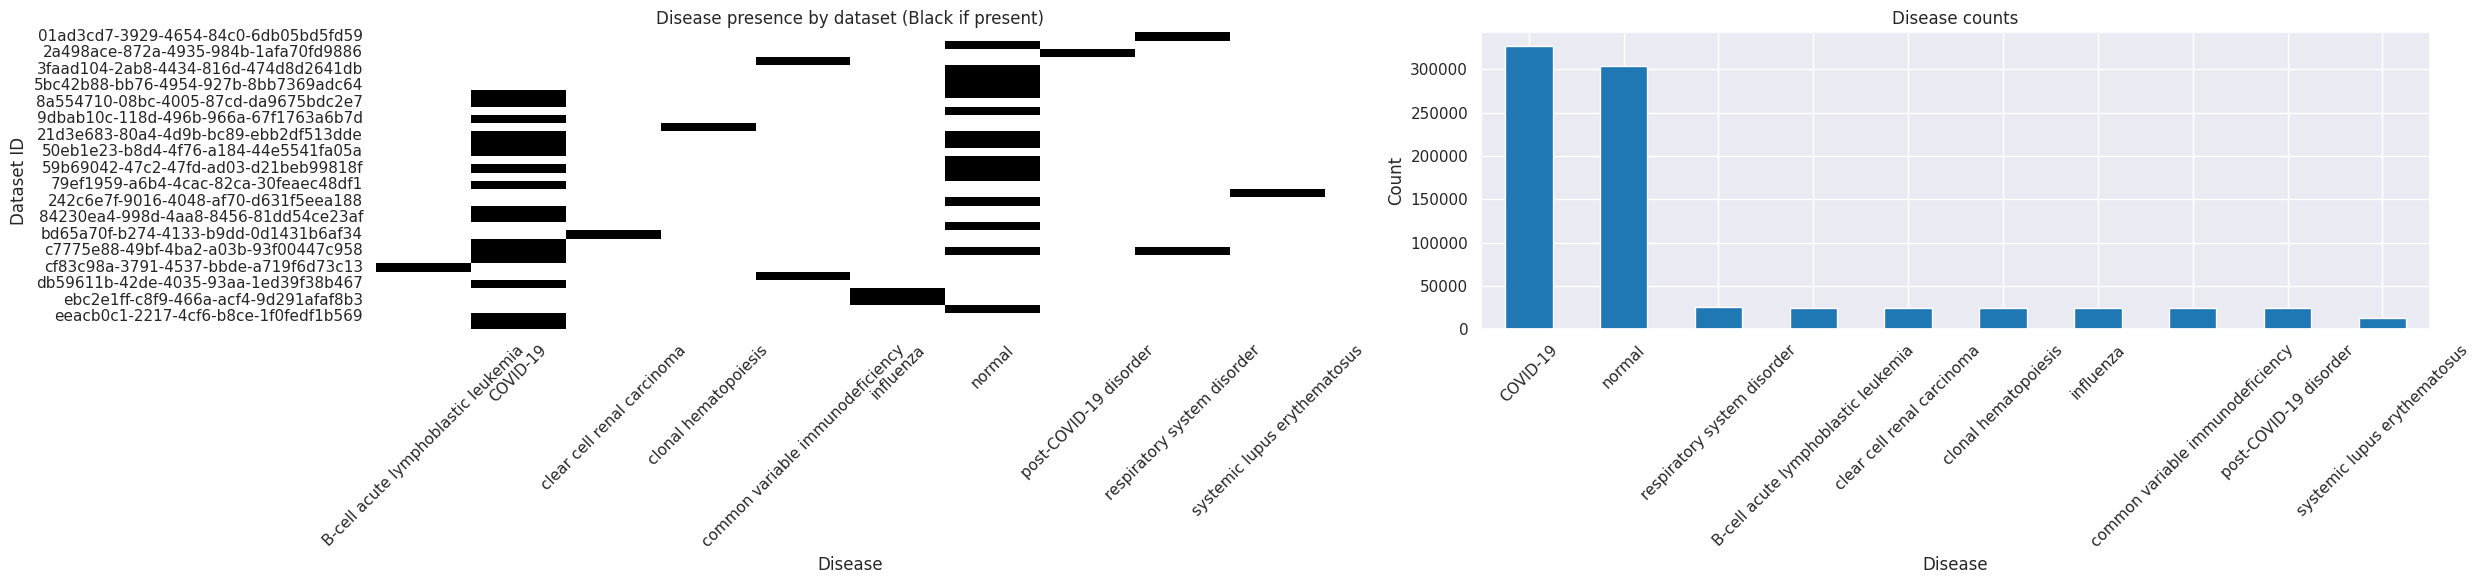

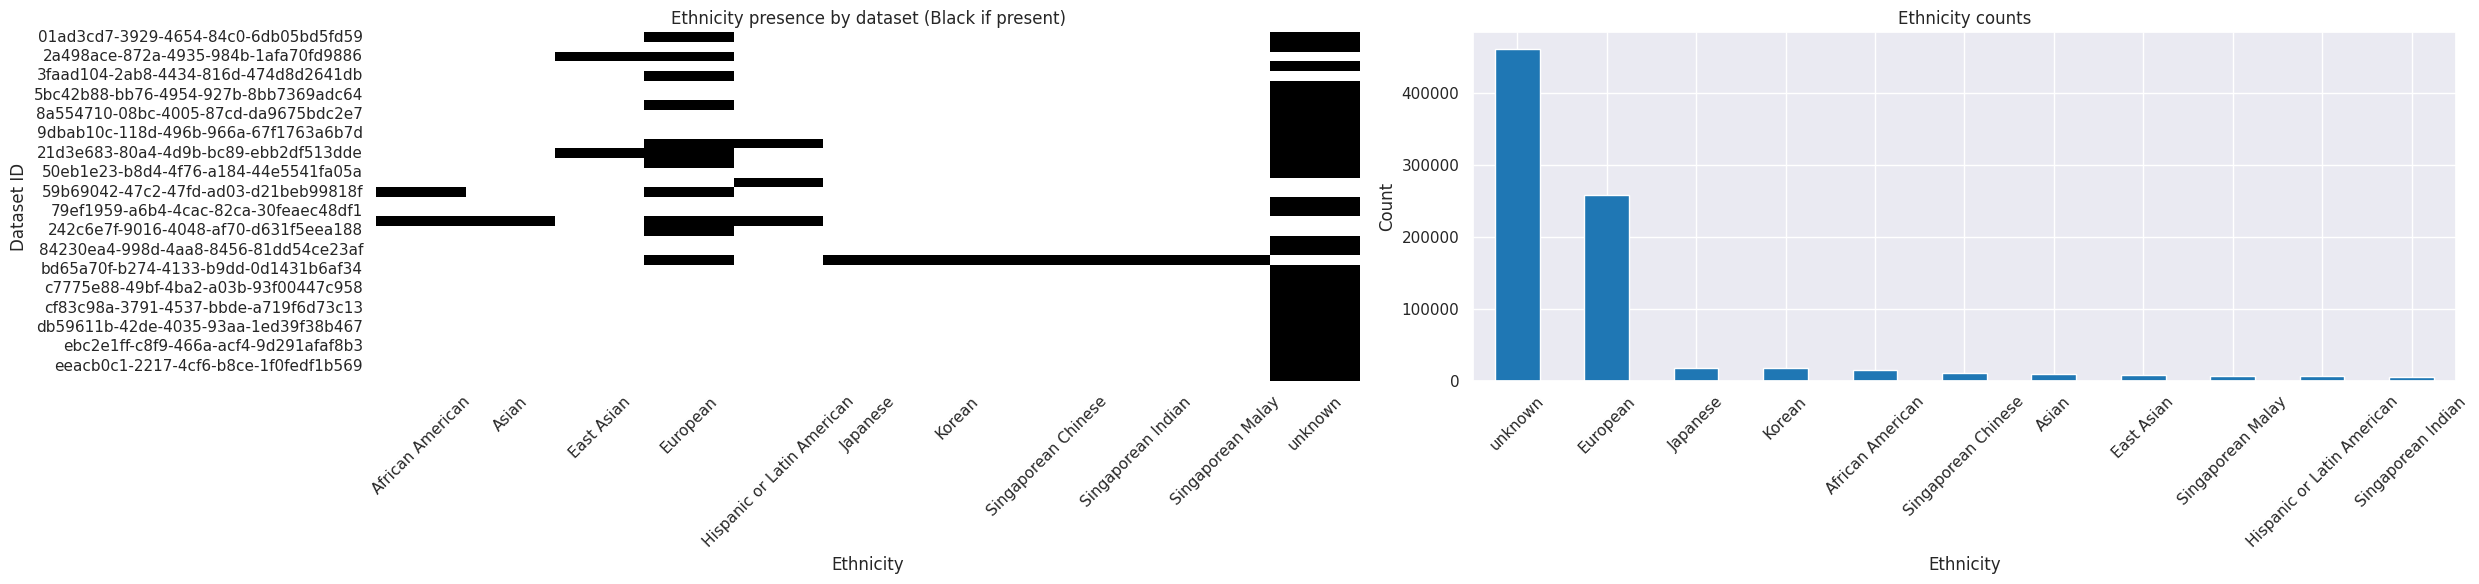

In [10]:
pairs = [
    ('age_category', 'Age Category'),
    ('sex', 'Sex'),
    ('disease', 'Disease'),
    ('self_reported_ethnicity', 'Ethnicity'),
]

for col, label in pairs:
    presence = (pd.crosstab(data.obs['dataset_id'], data.obs[col]) > 0).astype(int)
    counts = data.obs[col].value_counts(dropna=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))
    
    # Heatmap on the left
    sns.heatmap(presence, cmap='Greys', cbar=False, ax=ax1)
    ax1.set_title(f'{label} presence by dataset (Black if present)')
    ax1.set_xlabel(label)
    ax1.set_ylabel('Dataset ID')
    ax1.tick_params(axis='x', rotation=45)
    
    # Bar plot on the right
    counts.plot(kind='bar', color='tab:blue', ax=ax2)
    ax2.set_title(f'{label} counts')
    ax2.set_xlabel(label)
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


In [11]:
#Processing the data for the geneformer classifiers
filtered_anndata_sex=data[data.obs['sex']!='unknown']
filtered_anndata_etnicity=data[data.obs['self_reported_ethnicity'].isin([ 'East Asian', 'European','Hispanic or Latin American'])]
filtered_anndata_disease=data[data.obs['disease'].isin(['COVID-19', 'normal'])]
filtered_anndata_age=data[data.obs['age_category'].isin(['Senior_70', 'Senior_50', 'Young_Adulthood', 'Senior_60', 'Middle_Age', 'Infancy', 'Childhood'])]

In [13]:
#Save the anndata for the geneformer classifiers
filtered_anndata_sex.write_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/sex/geneformer_2048/anndata/complete_anndata.h5ad")
filtered_anndata_etnicity.write_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/ethnicity/geneformer_2048/data/complete_anndata.h5ad")
filtered_anndata_disease.write_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/disease/geneformer_2048/complete_anndata/complete_anndata.h5ad")
filtered_anndata_age.write_h5ad("/hpcfs/users/a1841503/Geneformer/cellnexus/data/age_bins/anndata/complete_age/complete_anndata.h5ad")